### импорт модулей


In [1]:
import re
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter 
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import string
lst_stopwords = nltk.corpus.stopwords.words('russian')
lst_stopwords.extend(['…', '«', '»', '...'])


### импорт файла (поменяйте на / все \  и оставьте r) 


In [2]:
def import_file(file_path):
    df_raw = pd.read_excel(file_path)
    df_raw.dropna(inplace=True)
    df_raw.rename(columns={'text': 'content'}, inplace=True)
    return df_raw

In [3]:
df_raw=import_file(r"../clust_analize/Московский постамат_Дата-cет_Этап 1.xlsx",)


In [4]:
df_raw #весь датасет

,Комментарий,Дата,Оценка,Сумма заказа
0,"Благодарю за заказ! Рада получению, но заказыв...",2022-12-15T15:58:09.796075+03:00,3,2450.0
1,"Все подошло, отличное качество",2022-11-07T23:37:52.541536+03:00,5,699.0
2,"Упаковано все хорошо, только транспортировочна...",2022-12-13T21:24:31.155951+03:00,4,954.0
3,"Быстро, удобно.",2022-11-09T17:55:44.379634+03:00,5,269.0
4,👍,2022-11-09T20:49:11.383462+03:00,5,229.0
...,...,...,...,...
124995,Качество звука на 3 из 10👎,2022-10-21T06:42:45.861705+03:00,5,899.0
124996,"Все организовано хорошо, но от нас долековато.",2022-10-25T07:53:15.062592+03:00,5,754.0
124997,"Удобное получение. Приятно, что можно зайти в ...",2022-10-22T11:25:16.25381+03:00,5,217.0
124998,Отлично.,2022-10-24T21:42:42.771919+03:00,5,459.0


In [5]:
def clean_text(text, tokenizer, stopwords):

    text = str(text).lower()  
    text = re.sub(r"\[(.*?)\]", "", text)  
    text = re.sub(r"\s+", " ", text)  
    text = re.sub(r"\w+…|…", "", text)  
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  
    text = re.sub(r"[0-9]", "", text)
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  

    tokens = tokenizer(text)  
    tokens = [t for t in tokens if not t in lst_stopwords]  
    tokens = ["" if t.isdigit() else t for t in tokens]  
    tokens = [t for t in tokens if len(t) > 1] 
    return tokens

In [6]:
def prep_tokens(df_raw):
    text_columns = ["Комментарий"]
    # df_raw['content'] = df_raw['content'].fillna(" ")
    # for col in text_columns:
    #     df_raw[col] = df_raw[col].astype(str)
    # создаем текст основанный на content title и tag
    df_raw["text"] = df_raw[text_columns].apply(lambda x: " | ".join(x), axis=1)
    df_raw["tokens"] = df_raw["text"].map(lambda x: clean_text(x, word_tokenize, lst_stopwords))
    _, idx = np.unique(df_raw["tokens"], return_index=True)
    df_raw = df_raw.iloc[idx, :]

    # Remove empty values
    df_raw = df_raw.loc[df_raw.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]
    return df_raw
    

In [7]:
prep_data=prep_tokens(df_raw)

In [8]:
prep_data

,text,tokens
23067,A&D отличное качество тонометров,"[ad, отличное, качество, тонометров]"
80214,All good. Well packed,"[all, good, well, packed]"
82384,All right,"[all, right]"
47417,alles ist gut,"[alles, ist, gut]"
43427,"Allles gut, ich bin gluklich!","[allles, gut, ich, bin, gluklich]"
...,...,...
53034,🤩🤗👏,[🤩🤗👏]
35491,🤩🤩🤩,[🤩🤩🤩]
46714,🤩🤩🤩🤩,[🤩🤩🤩🤩]
68385,🤬📦🖕,[🤬📦🖕]


In [9]:
docs = prep_data["text"].values
tokenized_docs = prep_data["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [10]:
vocab

Counter({'ad': 4,
         'отличное': 578,
         'качество': 2220,
         'тонометров': 2,
         'all': 7,
         'good': 17,
         'well': 3,
         'packed': 1,
         'right': 2,
         'alles': 1,
         'ist': 1,
         'gut': 5,
         'allles': 1,
         'ich': 1,
         'bin': 2,
         'gluklich': 1,
         'amperkinru': 1,
         'бессовестный': 1,
         'продавец': 899,
         'отправил': 88,
         'вместо': 1771,
         'рамок': 7,
         'schnider': 1,
         'electrik': 1,
         'постов': 1,
         'рублей': 370,
         'две': 479,
         'дешевые': 16,
         'лампочки': 95,
         'красная': 34,
         'цена': 1507,
         'которым': 33,
         'понимаю': 130,
         'сих': 69,
         'пор': 83,
         'забанили': 1,
         'обыкновенный': 8,
         'аферист': 2,
         'добросовестный': 6,
         'apple': 13,
         'watch': 6,
         'заряжает': 123,
         'aqva': 1,
         'по

In [11]:
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

### создаем модель и получаем вектора для кластерного анализа

In [12]:
model = Word2Vec(sentences=prep_data['tokens'].values, vector_size=100, window=5, min_count=1, workers=4)

In [13]:
from gensim.models import Word2Vec, KeyedVectors
model.wv.save_word2vec_format('model.bin', binary=True)

In [14]:
vectorized_docs= vectorize(prep_data['tokens'], model=model)
len(vectorized_docs), len(vectorized_docs[0])

(91882, 100)

In [15]:
vectorized_docs

[array([-0.18761167, -0.70610625, -0.27921137, -0.13722754, -0.33404696,
        -0.37544248,  0.3214545 ,  0.51369745,  0.30247572, -0.20828052,
         0.43488926,  0.20193487, -0.1884302 ,  0.5044645 , -0.10288202,
        -0.07577503, -0.23755285,  0.26824087,  0.015798  , -0.93283266,
        -0.4981254 , -0.12047543,  0.9811672 , -0.52737546,  0.21195322,
        -0.14198776,  0.03101257, -0.8707435 ,  0.08101012,  0.14272407,
         0.5088593 , -0.42538607,  0.17821032, -0.4546459 ,  0.02676382,
         0.3842508 , -0.55261606, -0.7620761 , -0.44688794, -0.9175679 ,
         0.33154628, -0.7697694 , -0.04166796, -0.66041714,  1.014769  ,
         0.28431064, -0.09208405, -0.70477706, -0.46971774,  0.6098595 ,
         0.43544915, -0.40142852, -0.1400061 ,  0.28384125, -0.5462938 ,
        -0.4608112 ,  0.29416278, -0.37563902, -0.70328367,  0.13516639,
        -0.11634727, -0.30879584,  0.98211426,  0.07792855,  0.10711682,
         0.72948575,  0.18666407,  0.5292002 , -0.7

In [16]:
prep_data['vectors'] =vectorized_docs
prep_data.fillna('')

,text,tokens,vectors
23067,A&D отличное качество тонометров,"[ad, отличное, качество, тонометров]","[-0.18761167, -0.70610625, -0.27921137, -0.137..."
80214,All good. Well packed,"[all, good, well, packed]","[-0.011526562, 0.015824325, 0.035525914, 0.013..."
82384,All right,"[all, right]","[-0.0120596895, 0.012561657, 0.027778758, 0.01..."
47417,alles ist gut,"[alles, ist, gut]","[0.003041946, 0.0056718383, 0.0032636847, 0.00..."
43427,"Allles gut, ich bin gluklich!","[allles, gut, ich, bin, gluklich]","[0.000120624805, 0.010274136, 0.007143625, 0.0..."
...,...,...,...
53034,🤩🤗👏,[🤩🤗👏],"[-0.008728414, 0.008210956, -0.009713482, -0.0..."
35491,🤩🤩🤩,[🤩🤩🤩],"[-0.0031510997, 0.004184644, -0.0061223125, 0...."
46714,🤩🤩🤩🤩,[🤩🤩🤩🤩],"[-0.008018767, -0.005854262, -0.00024125814, -..."
68385,🤬📦🖕,[🤬📦🖕],"[-0.003430686, 0.009557047, 0.007914965, -0.00..."


In [17]:
import pickle 
def mbkmeans_clusters(X, k, mb=3000, print_silhouette_values=False):

    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    with open('model.pkl','wb') as f:
        pickle.dump(km,f)
    return km, km.labels_

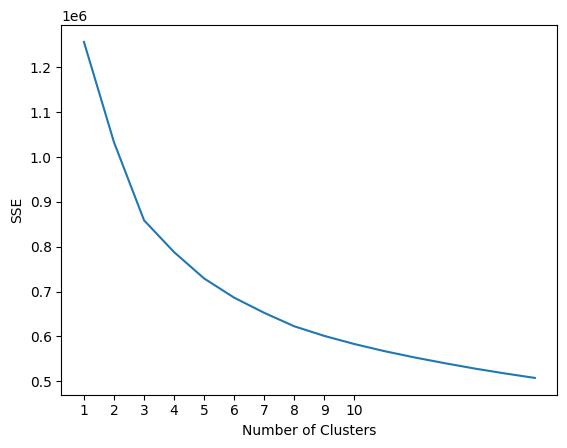

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,KMeans

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 17):
    kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(prep_data['vectors'].tolist())
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 17), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [19]:
sse

[1256722.0409560117,
 1032954.9206484588,
 858957.3412838873,
 787996.5459749514,
 729288.2841521911,
 686463.3367399608,
 652671.2071148737,
 622675.8273740337,
 601221.4140025328,
 583144.501849188,
 567288.522712852,
 553289.0204057156,
 540530.4483091827,
 528531.0010199202,
 517697.52057930874,
 507650.1384670175]

In [20]:
clustering, cluster_labels = mbkmeans_clusters(X=prep_data['vectors'].tolist(),k=8, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

c:\Users\Jora\Desktop\hack_lct\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8
Silhouette coefficient: 0.14
Inertia:649528.7933777804
Silhouette values:
    Cluster 6: Size:24841 | Avg:0.31 | Min:0.04 | Max: 0.49
    Cluster 1: Size:5988 | Avg:0.21 | Min:-0.09 | Max: 0.41
    Cluster 3: Size:8908 | Avg:0.10 | Min:-0.14 | Max: 0.34
    Cluster 2: Size:6978 | Avg:0.07 | Min:-0.16 | Max: 0.28
    Cluster 4: Size:8073 | Avg:0.06 | Min:-0.21 | Max: 0.30
    Cluster 7: Size:16707 | Avg:0.06 | Min:-0.20 | Max: 0.30
    Cluster 0: Size:11975 | Avg:0.05 | Min:-0.25 | Max: 0.32
    Cluster 5: Size:8412 | Avg:0.04 | Min:-0.16 | Max: 0.23


In [21]:
prep_data['lables']=cluster_labels
prep_data[prep_data['lables']==0]

,text,tokens,vectors,lables
51542,"Не Hasbro, мятая упаковка","[hasbro, мятая, упаковка]","[0.65497434, 0.40104106, 0.93763906, 0.9111889...",0
33263,"Palette Пришла не та краска ,которую заказывала","[palette, пришла, та, краска, которую, заказыв...","[-0.22904152, -0.2781831, 0.3716029, 0.3203845...",0
11610,Для ssd диска упаковка хлюпенькая. Да и упаков...,"[ssd, диска, упаковка, хлюпенькая, упаковкой, ...","[-0.093114704, 0.45891476, 0.4933421, 0.210770...",0
92178,"Vanish приехал не в банке, а в пакете","[vanish, приехал, банке, пакете]","[-0.34340912, -0.023990288, 0.34856987, 0.2908...",0
93146,Абразивные круги пришли не той зернистости . З...,"[абразивные, круги, пришли, той, зернистости, ...","[-0.25488877, -0.53071356, 0.14241715, -0.0290...",0
...,...,...,...,...
104546,В ячейку постомата коробку с заказанной кофемо...,"[ячейку, постомата, коробку, заказанной, кофем...","[-0.05317769, 0.38058266, 0.5218993, 0.1680504...",0
107493,Ящик забили в маленький отсек.Еле достали коро...,"[ящик, забили, маленький, отсекеле, достали, к...","[-0.087441616, 0.9654373, 0.7905347, 0.0197115...",0
65786,"Ящик не был упакован, но бутылки с водойвдовол...","[ящик, упакован, бутылки, водойвдовольно, креб...","[-0.21558054, 0.6061765, 0.6550913, 0.27910668...",0
124246,"Ёмкость открыта, всё содержимое вытекло.","[ёмкость, открыта, всё, содержимое, вытекло]","[-0.09686138, 0.61612123, 0.5843735, 0.2958189...",0


In [23]:
print("Самые популярные темы в кластере:")
for i in range(8):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Самые популярные темы в кластере:
Cluster 0: смесью рассыпался грязи разлит лежало 
Cluster 1: живу район постмат далеко отдел 
Cluster 2: задержек своевременно ожидалось молодцы замечательно 
Cluster 3: кассе пастомате пошла оператору кабинете 
Cluster 4: пятницу утром днём предупредили сутки 
Cluster 5: молодцы замечательно задержек своевременно отлично👍 
Cluster 6: предварительно нормальной спал начали говорит 
Cluster 7: порадовал класс прекрасный замечательный 👍👍👍 


In [24]:
test_cluster = 0

most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

Обычно корм приходит в коробке или обёрнут плёнкой. В этот раз не стали ничего делать, в итоге упаковка корма повреждена в некоторых местах
-------------
Заказывала чай в подарочной упаковке - металлической банке. Банка пришла мятая с лицевой стороны. Выправить не получилось. Неприятно.
-------------
Товар в упаковке в постамате лежал вместо того чтобы стоять как было обозначено на упаковке стрелками! Это всё-таки краска! Или вы не знаете что она житкая и могла вытечь! К тому же после распаковки банка с краской была повреждена (помята) с двух сторон! Сама банка с боку и крышка!
-------------
Любимое печенье. 
Заказ пришел в мягкой упаковке, коробки с печеньем оказались сильно помяты. ((
-------------
Товар упакован не корректно, валетом, что привело к поломке крышки одной из бутылок, в результате половина моющего средства вытекло и наполнило упаковку внутри, в итоге упаковка была повреждена.
Я получил брак, заплатил за 2 упаковки, а получил 1,5
-------------
Привезли товар , не в той у

In [25]:
some_text=['Пришёл товар помята крышка отвратительное качество']
exper=pd.DataFrame(some_text,columns=['Комментарий'])
prep_tokens(exper).iloc[:,1]


0    [пришёл, товар, помята, крышка, отвратительное...
Name: tokens, dtype: object

In [26]:
def get_lable(some_text):
    exper=pd.DataFrame(some_text,columns=['Комментарий'])
    vectorized_dox=vectorize(prep_tokens(exper).iloc[:,1], model=model)
    return vectorized_dox
    


In [27]:
get_lable(some_text)

[array([-0.4020815 , -0.34749636,  0.31175196,  0.32744423, -0.5345318 ,
        -0.77859783,  0.9544262 ,  0.82958907, -0.16069536, -0.26582018,
         0.03284548, -0.69501024, -0.3143269 ,  0.7013678 , -0.1273498 ,
        -0.71638113, -0.6241481 ,  0.08933864, -0.20088755, -1.4747623 ,
         0.4257876 , -0.288324  ,  1.0721151 , -0.05477049,  0.24007402,
         0.36393094, -0.01337946, -0.7346971 , -0.09036187, -0.26294664,
         0.7558276 ,  0.25398275,  0.42562178, -0.5193021 ,  0.53371084,
         0.47531602, -0.22837584, -0.7145012 , -1.6830535 , -1.6335889 ,
         0.6731987 , -1.2959137 ,  0.373176  , -0.3669769 ,  0.54167837,
        -0.1827051 , -0.740309  , -0.7402839 , -0.4284544 ,  0.8150513 ,
         0.25326678, -0.6195035 , -0.5355974 ,  0.1711558 , -0.9963463 ,
         0.04272576,  0.3407538 ,  0.1165949 , -0.75278926,  0.56571764,
        -0.2568929 , -0.7618479 ,  0.99990845, -0.44257239, -1.0102712 ,
         0.8169959 ,  0.46203962,  1.6711291 , -1.6

In [28]:
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)
clf2.predict(get_lable(some_text))

array([0])